In [1]:
import os, torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.6
CUDA available?: True
Device count: 1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from semisupervised import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder
from dimensionality_reduction import DimensionalityReductionAAE

## Fixed Experiment

In [3]:
NUM_EPOCHS = 100
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 2
PRIOR_STD = 1.0
RESULT_FOLDER = 'dimensionality_reduction_results/100_epochs_adam_eta_1000_results'
NUM_LABELED = 1000
eta = 1000

recon_loss = nn.MSELoss()
init_recon_lr = 0.001 #0.01
# init_recon_lr = 0.01

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.01 #0.1
# init_semi_sup_lr = 0.1

init_gen_lr = init_disc_lr = 0.001 #0.1
# init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = False

In [4]:
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import datasets, transforms
import torch, numpy as np


class UnlabeledWrapper(Dataset):
    """Return images only; label is always -1."""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        return x, -1


def configure_mnist(batch_size=100, n_labeled=1000, val_fraction=0.10, seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))          # flatten to 784
    ])

    full_train = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    rng = np.random.RandomState(seed)
    all_idx       = np.arange(len(full_train))                       # 60 000 indices
    labeled_idx   = rng.choice(all_idx, size=n_labeled, replace=False)
    remaining_idx = np.setdiff1d(all_idx, labeled_idx)

    n_val   = int(len(remaining_idx) * val_fraction)
    val_idx = rng.choice(remaining_idx, size=n_val, replace=False)
    unlabeled_idx = np.setdiff1d(remaining_idx, val_idx)

    labeled_ds     = Subset(full_train, labeled_idx)                 # (x, y)
    val_ds         = Subset(full_train, val_idx)                     # (x, y)
    unlabeled_ds   = UnlabeledWrapper(full_train, unlabeled_idx)     # (x, -1)

    train_labeled_loader   = DataLoader(labeled_ds,   batch_size=batch_size, shuffle=True,  drop_last=True)
    train_unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader             = DataLoader(val_ds,       batch_size=batch_size, shuffle=False)
    test_loader            = DataLoader(test_ds,      batch_size=batch_size, shuffle=False)

    X_lab = torch.stack([x for x, _ in labeled_ds])
    Y_lab = torch.tensor([y for _, y in labeled_ds])

    X_val = torch.stack([x for x, _ in val_ds])
    Y_val = torch.tensor([y for _, y in val_ds])

    X_test = torch.stack([x for x, _ in test_ds])
    Y_test = test_ds.targets.clone()

    return (X_lab, X_val, X_test,
            Y_lab, Y_val, Y_test,
            train_labeled_loader, train_unlabeled_loader, val_loader, test_loader)

In [5]:
(X_lab, X_val, X_test,
 Y_lab, Y_val, Y_test,
 train_labeled_loader,
 train_unlabeled_loader,
 val_loader,
 test_loader) = configure_mnist(batch_size=BATCH_SIZE, n_labeled=NUM_LABELED)

print("labelled   :", len(train_labeled_loader.dataset))   # 1 000
print("unlabelled :", len(train_unlabeled_loader.dataset)) # ≈53 000
print("val        :", len(val_loader.dataset))             # ≈6 000
print(Y_lab.max(), Y_lab.min())      

labelled   : 1000
unlabelled : 53100
val        : 5900
tensor(9) tensor(0)


In [6]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = DimensionalityReductionAAE(options, eta=eta)
print(model)

DimensionalityReductionAAE(
  (encoder): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=784, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1000, out_features=12, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=2, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1000, out_features=784, bias=True)
    )
  )
  (cat_softmax): Softmax(dim=1)
  (discriminator_categorical): Discriminator(
    (fc): Sequential(
      (0): Linear(in_features=10, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1000, out_features=1, bias=True)
    )
  )
  (discriminator_style): Discriminator(
    (fc): Sequential(
  

In [7]:
model.train_mbgd_2(
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE,
    train_labeled_loader=train_labeled_loader,
    train_unlabeled_loader=train_unlabeled_loader
)

Epoch [1/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100 — Recon_U: 998.8118, Recon_L: 998.8120, SemiSup: 2.3429, Disc_Cat: 1.3530, Gen_Cat: 0.6783, Disc_Sty: 1.3460, Gen_Sty: 0.7010
Validation Accuracy: 65.78%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [2/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/100 — Recon_U: 998.7751, Recon_L: 998.7741, SemiSup: 0.8305, Disc_Cat: 1.2934, Gen_Cat: 0.6652, Disc_Sty: 1.2226, Gen_Sty: 0.7183
Validation Accuracy: 81.75%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [3/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/100 — Recon_U: 998.7568, Recon_L: 998.7567, SemiSup: 0.5005, Disc_Cat: 1.2391, Gen_Cat: 0.7680, Disc_Sty: 1.6927, Gen_Sty: 0.6881
Validation Accuracy: 86.12%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [4/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/100 — Recon_U: 998.7403, Recon_L: 998.7400, SemiSup: 0.3973, Disc_Cat: 1.2178, Gen_Cat: 0.9049, Disc_Sty: 1.6151, Gen_Sty: 1.0643
Validation Accuracy: 86.07%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [5/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/100 — Recon_U: 998.7244, Recon_L: 998.7244, SemiSup: 0.3399, Disc_Cat: 1.1593, Gen_Cat: 1.1506, Disc_Sty: 1.2021, Gen_Sty: 1.5196
Validation Accuracy: 87.46%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [6/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/100 — Recon_U: 998.7095, Recon_L: 998.7087, SemiSup: 0.2269, Disc_Cat: 1.1811, Gen_Cat: 1.2656, Disc_Sty: 1.1975, Gen_Sty: 1.3316
Validation Accuracy: 89.75%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [7/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/100 — Recon_U: 998.6925, Recon_L: 998.6926, SemiSup: 0.2538, Disc_Cat: 1.2446, Gen_Cat: 1.1198, Disc_Sty: 1.5270, Gen_Sty: 0.6393
Validation Accuracy: 89.31%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [8/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/100 — Recon_U: 998.6767, Recon_L: 998.6762, SemiSup: 0.2397, Disc_Cat: 1.2467, Gen_Cat: 1.1250, Disc_Sty: 1.5196, Gen_Sty: 0.5323
Validation Accuracy: 88.83%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [9/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/100 — Recon_U: 998.6595, Recon_L: 998.6599, SemiSup: 0.2566, Disc_Cat: 1.2564, Gen_Cat: 1.1015, Disc_Sty: 1.3111, Gen_Sty: 0.6783
Validation Accuracy: 89.49%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [10/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/100 — Recon_U: 998.6447, Recon_L: 998.6442, SemiSup: 0.2576, Disc_Cat: 1.2493, Gen_Cat: 1.1110, Disc_Sty: 1.1513, Gen_Sty: 0.9403
Validation Accuracy: 90.15%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [11/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/100 — Recon_U: 998.6283, Recon_L: 998.6286, SemiSup: 0.2057, Disc_Cat: 1.2528, Gen_Cat: 1.1483, Disc_Sty: 1.5413, Gen_Sty: 0.8652
Validation Accuracy: 90.73%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [12/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/100 — Recon_U: 998.6133, Recon_L: 998.6128, SemiSup: 0.1800, Disc_Cat: 1.2296, Gen_Cat: 1.1812, Disc_Sty: 1.7021, Gen_Sty: 0.8442
Validation Accuracy: 89.69%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [13/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/100 — Recon_U: 998.5983, Recon_L: 998.5976, SemiSup: 0.1726, Disc_Cat: 1.2570, Gen_Cat: 1.0919, Disc_Sty: 1.3359, Gen_Sty: 1.0786
Validation Accuracy: 89.27%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [14/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/100 — Recon_U: 998.5817, Recon_L: 998.5818, SemiSup: 0.1609, Disc_Cat: 1.2339, Gen_Cat: 1.1788, Disc_Sty: 1.2455, Gen_Sty: 1.0904
Validation Accuracy: 90.58%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [15/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/100 — Recon_U: 998.5668, Recon_L: 998.5662, SemiSup: 0.1180, Disc_Cat: 1.2492, Gen_Cat: 1.1576, Disc_Sty: 1.3532, Gen_Sty: 0.8322
Validation Accuracy: 91.47%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [16/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/100 — Recon_U: 998.5505, Recon_L: 998.5504, SemiSup: 0.1148, Disc_Cat: 1.2887, Gen_Cat: 1.0735, Disc_Sty: 1.4174, Gen_Sty: 0.7710
Validation Accuracy: 90.27%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [17/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/100 — Recon_U: 998.5347, Recon_L: 998.5346, SemiSup: 0.1021, Disc_Cat: 1.3050, Gen_Cat: 1.0443, Disc_Sty: 1.3320, Gen_Sty: 0.8050
Validation Accuracy: 91.08%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [18/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/100 — Recon_U: 998.5197, Recon_L: 998.5189, SemiSup: 0.1693, Disc_Cat: 1.3020, Gen_Cat: 1.0159, Disc_Sty: 1.2936, Gen_Sty: 0.7947
Validation Accuracy: 90.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [19/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/100 — Recon_U: 998.5045, Recon_L: 998.5033, SemiSup: 0.0972, Disc_Cat: 1.3168, Gen_Cat: 0.9858, Disc_Sty: 1.3525, Gen_Sty: 0.8414
Validation Accuracy: 90.24%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [20/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/100 — Recon_U: 998.4903, Recon_L: 998.4883, SemiSup: 0.0984, Disc_Cat: 1.2694, Gen_Cat: 1.0218, Disc_Sty: 1.3955, Gen_Sty: 0.8828
Validation Accuracy: 90.12%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [21/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/100 — Recon_U: 998.4723, Recon_L: 998.4722, SemiSup: 0.1263, Disc_Cat: 1.3199, Gen_Cat: 0.9522, Disc_Sty: 1.3272, Gen_Sty: 0.9062
Validation Accuracy: 90.98%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [22/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/100 — Recon_U: 998.4571, Recon_L: 998.4565, SemiSup: 0.1150, Disc_Cat: 1.2742, Gen_Cat: 0.9947, Disc_Sty: 1.2995, Gen_Sty: 0.8665
Validation Accuracy: 89.93%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [23/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/100 — Recon_U: 998.4405, Recon_L: 998.4402, SemiSup: 0.1626, Disc_Cat: 1.3029, Gen_Cat: 0.9532, Disc_Sty: 1.3232, Gen_Sty: 0.8548
Validation Accuracy: 89.78%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [24/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/100 — Recon_U: 998.4254, Recon_L: 998.4245, SemiSup: 0.1496, Disc_Cat: 1.2835, Gen_Cat: 0.9705, Disc_Sty: 1.3725, Gen_Sty: 0.7804
Validation Accuracy: 90.51%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [25/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/100 — Recon_U: 998.4096, Recon_L: 998.4079, SemiSup: 0.1081, Disc_Cat: 1.2965, Gen_Cat: 0.9396, Disc_Sty: 1.3374, Gen_Sty: 0.8414
Validation Accuracy: 89.24%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [26/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/100 — Recon_U: 998.3918, Recon_L: 998.3918, SemiSup: 0.1713, Disc_Cat: 1.2863, Gen_Cat: 0.9584, Disc_Sty: 1.2940, Gen_Sty: 0.8237
Validation Accuracy: 90.36%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [27/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/100 — Recon_U: 998.3772, Recon_L: 998.3759, SemiSup: 0.1003, Disc_Cat: 1.2700, Gen_Cat: 1.0300, Disc_Sty: 1.3155, Gen_Sty: 0.7932
Validation Accuracy: 90.39%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [28/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/100 — Recon_U: 998.3622, Recon_L: 998.3611, SemiSup: 0.0934, Disc_Cat: 1.2976, Gen_Cat: 0.9535, Disc_Sty: 1.3616, Gen_Sty: 0.8012
Validation Accuracy: 90.49%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [29/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/100 — Recon_U: 998.3466, Recon_L: 998.3449, SemiSup: 0.1260, Disc_Cat: 1.2786, Gen_Cat: 1.0191, Disc_Sty: 1.3398, Gen_Sty: 0.8599
Validation Accuracy: 89.66%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [30/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/100 — Recon_U: 998.3296, Recon_L: 998.3280, SemiSup: 0.1317, Disc_Cat: 1.3081, Gen_Cat: 0.9602, Disc_Sty: 1.3216, Gen_Sty: 0.8840
Validation Accuracy: 90.80%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [31/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/100 — Recon_U: 998.3119, Recon_L: 998.3116, SemiSup: 0.1187, Disc_Cat: 1.3013, Gen_Cat: 0.9675, Disc_Sty: 1.3376, Gen_Sty: 0.8002
Validation Accuracy: 91.24%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [32/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/100 — Recon_U: 998.2963, Recon_L: 998.2949, SemiSup: 0.1346, Disc_Cat: 1.2871, Gen_Cat: 0.9896, Disc_Sty: 1.3348, Gen_Sty: 0.7883
Validation Accuracy: 91.14%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [33/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/100 — Recon_U: 998.2792, Recon_L: 998.2781, SemiSup: 0.0918, Disc_Cat: 1.3002, Gen_Cat: 0.9617, Disc_Sty: 1.3062, Gen_Sty: 0.8607
Validation Accuracy: 91.02%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [34/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/100 — Recon_U: 998.2629, Recon_L: 998.2622, SemiSup: 0.0803, Disc_Cat: 1.3018, Gen_Cat: 0.9860, Disc_Sty: 1.3525, Gen_Sty: 0.8075
Validation Accuracy: 90.29%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [35/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/100 — Recon_U: 998.2462, Recon_L: 998.2456, SemiSup: 0.1537, Disc_Cat: 1.2959, Gen_Cat: 1.0042, Disc_Sty: 1.3479, Gen_Sty: 0.7933
Validation Accuracy: 89.25%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [36/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/100 — Recon_U: 998.2303, Recon_L: 998.2293, SemiSup: 0.0944, Disc_Cat: 1.3304, Gen_Cat: 0.9475, Disc_Sty: 1.3590, Gen_Sty: 0.7904
Validation Accuracy: 89.98%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [37/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/100 — Recon_U: 998.2130, Recon_L: 998.2121, SemiSup: 0.1029, Disc_Cat: 1.3118, Gen_Cat: 0.9584, Disc_Sty: 1.3524, Gen_Sty: 0.7733
Validation Accuracy: 89.68%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [38/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/100 — Recon_U: 998.1965, Recon_L: 998.1959, SemiSup: 0.0970, Disc_Cat: 1.3038, Gen_Cat: 0.9500, Disc_Sty: 1.3595, Gen_Sty: 0.7628
Validation Accuracy: 89.46%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [39/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/100 — Recon_U: 998.1791, Recon_L: 998.1789, SemiSup: 0.1139, Disc_Cat: 1.2970, Gen_Cat: 0.9596, Disc_Sty: 1.3247, Gen_Sty: 0.7933
Validation Accuracy: 89.69%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [40/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/100 — Recon_U: 998.1629, Recon_L: 998.1627, SemiSup: 0.1948, Disc_Cat: 1.3006, Gen_Cat: 0.9336, Disc_Sty: 1.3375, Gen_Sty: 0.7909
Validation Accuracy: 90.85%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [41/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/100 — Recon_U: 998.1483, Recon_L: 998.1465, SemiSup: 0.1072, Disc_Cat: 1.2975, Gen_Cat: 0.9996, Disc_Sty: 1.3497, Gen_Sty: 0.7656
Validation Accuracy: 90.03%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [42/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/100 — Recon_U: 998.1314, Recon_L: 998.1308, SemiSup: 0.1654, Disc_Cat: 1.3153, Gen_Cat: 0.9434, Disc_Sty: 1.3357, Gen_Sty: 0.7819
Validation Accuracy: 89.59%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [43/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/100 — Recon_U: 998.1145, Recon_L: 998.1146, SemiSup: 0.1146, Disc_Cat: 1.3167, Gen_Cat: 0.9625, Disc_Sty: 1.3809, Gen_Sty: 0.6992
Validation Accuracy: 90.69%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [44/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/100 — Recon_U: 998.0986, Recon_L: 998.0979, SemiSup: 0.0762, Disc_Cat: 1.3024, Gen_Cat: 0.9555, Disc_Sty: 1.4081, Gen_Sty: 0.7041
Validation Accuracy: 90.83%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [45/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/100 — Recon_U: 998.0803, Recon_L: 998.0805, SemiSup: 0.1297, Disc_Cat: 1.2940, Gen_Cat: 0.9254, Disc_Sty: 1.3873, Gen_Sty: 0.6992
Validation Accuracy: 90.00%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [46/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/100 — Recon_U: 998.0629, Recon_L: 998.0634, SemiSup: 0.1625, Disc_Cat: 1.3139, Gen_Cat: 0.9291, Disc_Sty: 1.3657, Gen_Sty: 0.6973
Validation Accuracy: 88.58%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [47/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/100 — Recon_U: 998.0480, Recon_L: 998.0465, SemiSup: 0.1332, Disc_Cat: 1.3160, Gen_Cat: 0.9223, Disc_Sty: 1.3714, Gen_Sty: 0.6785
Validation Accuracy: 89.22%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [48/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/100 — Recon_U: 998.0293, Recon_L: 998.0285, SemiSup: 0.1115, Disc_Cat: 1.3227, Gen_Cat: 0.8664, Disc_Sty: 1.3763, Gen_Sty: 0.7146
Validation Accuracy: 89.64%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [49/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/100 — Recon_U: 998.0126, Recon_L: 998.0119, SemiSup: 0.1656, Disc_Cat: 1.3105, Gen_Cat: 0.9097, Disc_Sty: 1.3842, Gen_Sty: 0.7212
Validation Accuracy: 89.49%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [50/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/100 — Recon_U: 997.9962, Recon_L: 997.9952, SemiSup: 0.1154, Disc_Cat: 1.3336, Gen_Cat: 0.8759, Disc_Sty: 1.3761, Gen_Sty: 0.7186
Validation Accuracy: 90.51%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_epoch_50/weights_*.pth
Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [51/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51/100 — Recon_U: 997.9844, Recon_L: 997.9837, SemiSup: 0.0663, Disc_Cat: 1.3204, Gen_Cat: 0.9047, Disc_Sty: 1.3882, Gen_Sty: 0.6783
Validation Accuracy: 90.54%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [52/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52/100 — Recon_U: 997.9823, Recon_L: 997.9813, SemiSup: 0.0796, Disc_Cat: 1.3232, Gen_Cat: 0.8337, Disc_Sty: 1.3848, Gen_Sty: 0.6779
Validation Accuracy: 90.69%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [53/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53/100 — Recon_U: 997.9806, Recon_L: 997.9793, SemiSup: 0.0561, Disc_Cat: 1.2989, Gen_Cat: 0.8697, Disc_Sty: 1.3781, Gen_Sty: 0.6812
Validation Accuracy: 90.76%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [54/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54/100 — Recon_U: 997.9770, Recon_L: 997.9775, SemiSup: 0.0480, Disc_Cat: 1.3065, Gen_Cat: 0.8669, Disc_Sty: 1.3832, Gen_Sty: 0.6783
Validation Accuracy: 90.83%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [55/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55/100 — Recon_U: 997.9766, Recon_L: 997.9754, SemiSup: 0.0801, Disc_Cat: 1.2944, Gen_Cat: 0.8909, Disc_Sty: 1.3844, Gen_Sty: 0.6798
Validation Accuracy: 91.03%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [56/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56/100 — Recon_U: 997.9747, Recon_L: 997.9735, SemiSup: 0.0836, Disc_Cat: 1.3081, Gen_Cat: 0.8503, Disc_Sty: 1.3841, Gen_Sty: 0.6794
Validation Accuracy: 91.07%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [57/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57/100 — Recon_U: 997.9721, Recon_L: 997.9720, SemiSup: 0.0582, Disc_Cat: 1.3152, Gen_Cat: 0.8432, Disc_Sty: 1.3870, Gen_Sty: 0.6798
Validation Accuracy: 91.08%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [58/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58/100 — Recon_U: 997.9712, Recon_L: 997.9700, SemiSup: 0.0621, Disc_Cat: 1.3196, Gen_Cat: 0.8514, Disc_Sty: 1.3907, Gen_Sty: 0.6794
Validation Accuracy: 91.12%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [59/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59/100 — Recon_U: 997.9703, Recon_L: 997.9684, SemiSup: 0.1134, Disc_Cat: 1.3131, Gen_Cat: 0.8485, Disc_Sty: 1.3911, Gen_Sty: 0.6785
Validation Accuracy: 91.24%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [60/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60/100 — Recon_U: 997.9680, Recon_L: 997.9666, SemiSup: 0.0554, Disc_Cat: 1.3050, Gen_Cat: 0.8781, Disc_Sty: 1.3847, Gen_Sty: 0.6888
Validation Accuracy: 91.27%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [61/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61/100 — Recon_U: 997.9661, Recon_L: 997.9646, SemiSup: 0.1081, Disc_Cat: 1.3023, Gen_Cat: 0.8777, Disc_Sty: 1.3930, Gen_Sty: 0.6846
Validation Accuracy: 91.25%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [62/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62/100 — Recon_U: 997.9630, Recon_L: 997.9630, SemiSup: 0.0565, Disc_Cat: 1.3193, Gen_Cat: 0.8470, Disc_Sty: 1.3902, Gen_Sty: 0.6880
Validation Accuracy: 91.27%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [63/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63/100 — Recon_U: 997.9618, Recon_L: 997.9614, SemiSup: 0.0440, Disc_Cat: 1.3158, Gen_Cat: 0.8520, Disc_Sty: 1.3894, Gen_Sty: 0.6917
Validation Accuracy: 91.32%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [64/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64/100 — Recon_U: 997.9604, Recon_L: 997.9594, SemiSup: 0.0319, Disc_Cat: 1.3118, Gen_Cat: 0.8632, Disc_Sty: 1.3864, Gen_Sty: 0.6934
Validation Accuracy: 91.36%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [65/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65/100 — Recon_U: 997.9590, Recon_L: 997.9580, SemiSup: 0.0221, Disc_Cat: 1.3066, Gen_Cat: 0.8593, Disc_Sty: 1.3872, Gen_Sty: 0.6919
Validation Accuracy: 91.41%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [66/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66/100 — Recon_U: 997.9566, Recon_L: 997.9559, SemiSup: 0.0298, Disc_Cat: 1.3179, Gen_Cat: 0.8482, Disc_Sty: 1.3942, Gen_Sty: 0.6872
Validation Accuracy: 91.34%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [67/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67/100 — Recon_U: 997.9554, Recon_L: 997.9544, SemiSup: 0.0889, Disc_Cat: 1.3100, Gen_Cat: 0.8664, Disc_Sty: 1.3922, Gen_Sty: 0.6907
Validation Accuracy: 91.34%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [68/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68/100 — Recon_U: 997.9536, Recon_L: 997.9526, SemiSup: 0.0479, Disc_Cat: 1.3111, Gen_Cat: 0.8487, Disc_Sty: 1.3869, Gen_Sty: 0.6975
Validation Accuracy: 91.39%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [69/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69/100 — Recon_U: 997.9521, Recon_L: 997.9507, SemiSup: 0.0610, Disc_Cat: 1.3170, Gen_Cat: 0.8673, Disc_Sty: 1.3864, Gen_Sty: 0.6962
Validation Accuracy: 91.37%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [70/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70/100 — Recon_U: 997.9497, Recon_L: 997.9492, SemiSup: 0.0436, Disc_Cat: 1.3111, Gen_Cat: 0.8509, Disc_Sty: 1.3865, Gen_Sty: 0.6976
Validation Accuracy: 91.32%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [71/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71/100 — Recon_U: 997.9490, Recon_L: 997.9473, SemiSup: 0.0382, Disc_Cat: 1.3146, Gen_Cat: 0.8774, Disc_Sty: 1.3909, Gen_Sty: 0.6979
Validation Accuracy: 91.37%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [72/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72/100 — Recon_U: 997.9470, Recon_L: 997.9457, SemiSup: 0.0201, Disc_Cat: 1.3234, Gen_Cat: 0.8456, Disc_Sty: 1.3879, Gen_Sty: 0.7005
Validation Accuracy: 91.32%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [73/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73/100 — Recon_U: 997.9463, Recon_L: 997.9440, SemiSup: 0.0569, Disc_Cat: 1.3110, Gen_Cat: 0.8599, Disc_Sty: 1.3869, Gen_Sty: 0.6988
Validation Accuracy: 91.29%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [74/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74/100 — Recon_U: 997.9433, Recon_L: 997.9422, SemiSup: 0.0362, Disc_Cat: 1.3165, Gen_Cat: 0.8559, Disc_Sty: 1.3878, Gen_Sty: 0.7003
Validation Accuracy: 91.34%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [75/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75/100 — Recon_U: 997.9413, Recon_L: 997.9405, SemiSup: 0.0636, Disc_Cat: 1.3044, Gen_Cat: 0.8972, Disc_Sty: 1.3900, Gen_Sty: 0.6977
Validation Accuracy: 91.39%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [76/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76/100 — Recon_U: 997.9400, Recon_L: 997.9388, SemiSup: 0.0323, Disc_Cat: 1.3234, Gen_Cat: 0.8392, Disc_Sty: 1.3901, Gen_Sty: 0.7000
Validation Accuracy: 91.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [77/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77/100 — Recon_U: 997.9386, Recon_L: 997.9370, SemiSup: 0.0499, Disc_Cat: 1.3149, Gen_Cat: 0.8811, Disc_Sty: 1.3881, Gen_Sty: 0.6960
Validation Accuracy: 91.47%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [78/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78/100 — Recon_U: 997.9374, Recon_L: 997.9354, SemiSup: 0.0208, Disc_Cat: 1.3108, Gen_Cat: 0.8670, Disc_Sty: 1.3910, Gen_Sty: 0.6962
Validation Accuracy: 91.47%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [79/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79/100 — Recon_U: 997.9347, Recon_L: 997.9337, SemiSup: 0.0464, Disc_Cat: 1.3140, Gen_Cat: 0.8852, Disc_Sty: 1.3885, Gen_Sty: 0.6956
Validation Accuracy: 91.47%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [80/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80/100 — Recon_U: 997.9336, Recon_L: 997.9320, SemiSup: 0.0171, Disc_Cat: 1.3111, Gen_Cat: 0.8603, Disc_Sty: 1.3860, Gen_Sty: 0.6979
Validation Accuracy: 91.49%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [81/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81/100 — Recon_U: 997.9315, Recon_L: 997.9302, SemiSup: 0.0527, Disc_Cat: 1.3179, Gen_Cat: 0.8791, Disc_Sty: 1.3864, Gen_Sty: 0.6972
Validation Accuracy: 91.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [82/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82/100 — Recon_U: 997.9309, Recon_L: 997.9284, SemiSup: 0.0349, Disc_Cat: 1.3093, Gen_Cat: 0.8906, Disc_Sty: 1.3861, Gen_Sty: 0.6982
Validation Accuracy: 91.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [83/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83/100 — Recon_U: 997.9291, Recon_L: 997.9269, SemiSup: 0.0474, Disc_Cat: 1.3167, Gen_Cat: 0.8849, Disc_Sty: 1.3873, Gen_Sty: 0.6969
Validation Accuracy: 91.53%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [84/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84/100 — Recon_U: 997.9260, Recon_L: 997.9251, SemiSup: 0.0104, Disc_Cat: 1.3186, Gen_Cat: 0.8522, Disc_Sty: 1.3875, Gen_Sty: 0.6977
Validation Accuracy: 91.56%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [85/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85/100 — Recon_U: 997.9247, Recon_L: 997.9236, SemiSup: 0.0406, Disc_Cat: 1.3109, Gen_Cat: 0.8846, Disc_Sty: 1.3874, Gen_Sty: 0.6994
Validation Accuracy: 91.51%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [86/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86/100 — Recon_U: 997.9235, Recon_L: 997.9217, SemiSup: 0.0262, Disc_Cat: 1.3233, Gen_Cat: 0.8493, Disc_Sty: 1.3902, Gen_Sty: 0.6974
Validation Accuracy: 91.49%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [87/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87/100 — Recon_U: 997.9217, Recon_L: 997.9202, SemiSup: 0.0414, Disc_Cat: 1.3199, Gen_Cat: 0.8611, Disc_Sty: 1.3903, Gen_Sty: 0.6970
Validation Accuracy: 91.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [88/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88/100 — Recon_U: 997.9198, Recon_L: 997.9184, SemiSup: 0.0392, Disc_Cat: 1.3219, Gen_Cat: 0.8614, Disc_Sty: 1.3885, Gen_Sty: 0.7007
Validation Accuracy: 91.46%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [89/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89/100 — Recon_U: 997.9185, Recon_L: 997.9168, SemiSup: 0.0466, Disc_Cat: 1.3193, Gen_Cat: 0.8689, Disc_Sty: 1.3884, Gen_Sty: 0.7008
Validation Accuracy: 91.44%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [90/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90/100 — Recon_U: 997.9164, Recon_L: 997.9151, SemiSup: 0.0173, Disc_Cat: 1.3222, Gen_Cat: 0.8639, Disc_Sty: 1.3888, Gen_Sty: 0.6999
Validation Accuracy: 91.51%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [91/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91/100 — Recon_U: 997.9150, Recon_L: 997.9131, SemiSup: 0.0682, Disc_Cat: 1.3256, Gen_Cat: 0.8489, Disc_Sty: 1.3853, Gen_Sty: 0.7021
Validation Accuracy: 91.51%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [92/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92/100 — Recon_U: 997.9120, Recon_L: 997.9118, SemiSup: 0.0201, Disc_Cat: 1.3162, Gen_Cat: 0.8666, Disc_Sty: 1.3882, Gen_Sty: 0.7024
Validation Accuracy: 91.54%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [93/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93/100 — Recon_U: 997.9110, Recon_L: 997.9101, SemiSup: 0.0282, Disc_Cat: 1.3090, Gen_Cat: 0.8756, Disc_Sty: 1.3852, Gen_Sty: 0.7016
Validation Accuracy: 91.63%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [94/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94/100 — Recon_U: 997.9098, Recon_L: 997.9085, SemiSup: 0.0440, Disc_Cat: 1.3246, Gen_Cat: 0.8680, Disc_Sty: 1.3863, Gen_Sty: 0.7012
Validation Accuracy: 91.61%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [95/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95/100 — Recon_U: 997.9081, Recon_L: 997.9067, SemiSup: 0.0395, Disc_Cat: 1.3310, Gen_Cat: 0.8571, Disc_Sty: 1.3872, Gen_Sty: 0.7006
Validation Accuracy: 91.59%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [96/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96/100 — Recon_U: 997.9059, Recon_L: 997.9049, SemiSup: 0.0295, Disc_Cat: 1.3279, Gen_Cat: 0.8480, Disc_Sty: 1.3844, Gen_Sty: 0.7005
Validation Accuracy: 91.68%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [97/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97/100 — Recon_U: 997.9050, Recon_L: 997.9034, SemiSup: 0.0412, Disc_Cat: 1.3189, Gen_Cat: 0.8791, Disc_Sty: 1.3869, Gen_Sty: 0.6999
Validation Accuracy: 91.64%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [98/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98/100 — Recon_U: 997.9026, Recon_L: 997.9015, SemiSup: 0.0142, Disc_Cat: 1.3181, Gen_Cat: 0.8764, Disc_Sty: 1.3858, Gen_Sty: 0.6977
Validation Accuracy: 91.63%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [99/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99/100 — Recon_U: 997.9002, Recon_L: 997.8998, SemiSup: 0.0287, Disc_Cat: 1.3258, Gen_Cat: 0.8451, Disc_Sty: 1.3843, Gen_Sty: 0.6988
Validation Accuracy: 91.69%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


Epoch [100/100]:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100/100 — Recon_U: 997.9003, Recon_L: 997.8984, SemiSup: 0.0278, Disc_Cat: 1.3086, Gen_Cat: 0.8972, Disc_Sty: 1.3861, Gen_Sty: 0.6979
Validation Accuracy: 91.76%

Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_epoch_100/weights_*.pth
Weights saved to dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


## Accuracy Eval

In [8]:
model.load_weights("dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights")

Weights loaded from dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


In [9]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [10]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 91.68%


# Visualization

In [11]:
model.load_weights("dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights")

Weights loaded from dimensionality_reduction_results/100_epochs_adam_eta_1000_results/weights_*.pth


100%|██████████| 100/100 [00:03<00:00, 33.24it/s]


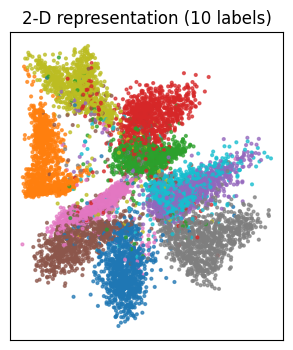

In [12]:
# ---------------------------------------------------------------
#  Visualising the Dimensionality-Reduction AAE embedding
#  (Figure-11 style: panels a–d)
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from sklearn.manifold import TSNE            # only used when n > 2

# ----------------------------------------------------------------
#  Replace these three handles with your own variables
# ----------------------------------------------------------------
model   = model                              # ❶ DimensionalityReductionAAE
loader  = test_loader                        # ❷ held-out / validation set
device  = torch.device("cuda:0")             # ❸ or "cpu"

# ----------------------------------------------------------------
# 1.  Pass the entire split through `embed`
# ----------------------------------------------------------------
Z, colours = [], []
model.eval()
with torch.no_grad():
    for x, y in tqdm(loader):
        x = x.to(device)
        z_batch = model.embed(x)             # (B, n)  ← new helper!
        Z.append(z_batch.cpu())

        # # decide how to colour points
        # if model.options.n_labelled == 0:        # fully unsupervised
        #     _, z_cat, _ = model.embed(x, return_parts=True)
        #     colours.append(z_cat.argmax(1).cpu())   # cluster id
        # else:                                    # semi/fully supervised
        colours.append(y.cpu())              # true digit label

Z       = torch.cat(Z).numpy()               # (N, n)
colours = torch.cat(colours).numpy()

# ----------------------------------------------------------------
# 2.  If n == 2  → direct scatter;  else project to 2-D first
# ----------------------------------------------------------------
if Z.shape[1] == 2:
    Z2 = Z
else:
    # Follow the paper: project 10-D style space so the K cluster
    # heads lie on a circle (optional); t-SNE works fine too.
    Z2 = TSNE(n_components=2, perplexity=30).fit_transform(Z)

# ----------------------------------------------------------------
# 3.  Plot
# ----------------------------------------------------------------
plt.figure(figsize=(4,4))
plt.scatter(Z2[:,0], Z2[:,1], c=colours, s=4, cmap='tab10', alpha=.7)
plt.gca().set(aspect='equal', xticks=[], yticks=[])
title = (f"{Z.shape[1]}-D representation "
         f"(10 labels)")
plt.title(title)
plt.show()
